# Notebook to run differential expression analysis using ´PyDeSeq2´

**Created by** : **Srivalli Kolla**

**Developed on** : 11 November,2024  

**Last Modified** : 12 November,2024 

**Institute of Systems Immunology, University of Wurzburg**

## Installation Instructions:

To install required packages using conda:
```bash
conda create -n pydeseq2
conda activate pydeseq2
conda install -c conda-forge scanpy anndata scipy pandas numpy requests matplotlib seaborn pydeseq2

Reference : https://pydeseq2.readthedocs.io/en/latest/

# Import Required Libraries

In [1]:
import scanpy as sc
import anndata
import scipy.sparse as sp
import pandas as pd
from scipy import sparse
import anndata as ad
import numpy as np
import datetime
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.sparse import issparse

from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
from itertools import product

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

timestamp = datetime.datetime.now().strftime("%d_%m_%y,%H:%M")
timestamp

-----
anndata     0.10.8
scanpy      1.10.2
-----
PIL                 10.3.0
asttokens           NA
certifi             2024.07.04
cffi                1.17.1
charset_normalizer  3.4.0
colorama            0.4.6
comm                0.2.2
cycler              0.12.1
cython_runtime      NA
dateutil            2.9.0.post0
debugpy             1.8.2
decorator           5.1.1
django              5.0.6
executing           2.0.1
h5py                3.11.0
idna                3.10
ipykernel           6.29.5
jedi                0.19.1
joblib              1.4.2
kiwisolver          1.4.5
legacy_api_wrap     NA
llvmlite            0.43.0
matplotlib          3.9.1
mpl_toolkits        NA
natsort             8.4.0
numba               0.60.0
numpy               1.26.4
packaging           24.1
pandas              2.2.2
parso               0.8.4
patsy               0.5.6
pickleshare         0.7.5
platformdirs        4.2.2
prompt_toolkit      3.0.47
psutil              6.0.0
pure_eval           0.2.2
pydeseq

'12_11_24,17:07'

## Helper Functions

In [3]:
# Function to Create Pseudobulks
def pseudobulk_from_adata(adata: ad.AnnData) -> ad.AnnData:
    return ad.AnnData(
        X=sparse.csr_matrix(adata.X.toarray().sum(axis=0)),
        obs=adata.obs[filter(lambda column: len(set(adata.obs[column])) == 1, adata.obs.columns)].head(1),
        var=adata.var
    )

# Function to Check for Raw Counts
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

# Data Import

Ensure that the data has raw counts

In [ ]:
a = sc.read_h5ad('../data/a_25_10_24,11:40.h5ad')
b = sc.read_h5ad('../data/b_25_10_24,11:49.h5ad')

b.X = b.layers['raw_counts'] 

adata = a.concatenate(b)

In [12]:
X_is_raw(adata)

True

# Data Preparation for DESeq2

Pseudobulks are preferably created per sample

In [13]:
pseudobulk = ad.concat(map(pseudobulk_from_adata, map(lambda batch: adata[adata.obs["sample"] == batch],set(adata.obs["sample"]))))
pseudobulk

AnnData object with n_obs × n_vars = 6 × 29378
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_leiden', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches', 'sample', 'seed_labels', 'genotype'

In [14]:
counts_df = pd.DataFrame(pseudobulk.X.toarray().astype(int), index=pseudobulk.obs_names, columns=pseudobulk.var_names)
metadata = pseudobulk.obs

# DESeq2 Analysis Setup

## Defining parameters for DE

In [17]:
inference = DefaultInference(n_cpus=8)

dds = DeseqDataSet(
    counts=counts_df,
    metadata=metadata,
    design_factors='genotype', # Group/Pseudobulk which you would like to consider for DE analysis 
    refit_cooks=True,
    inference=inference, 
    ref_level = ('genotype', 'WT') # Group which canm be used as reference
)

## DE analysis

In [20]:
dds.deseq2()

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 1.41 seconds.

Fitting dispersion trend curve...
... done in 0.27 seconds.

/home/skolla/miniforge3/envs/pydeseq2/lib/python3.12/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 1.33 seconds.

Fitting LFCs...
... done in 1.42 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



## Obtaining DE results

In [23]:
stat_res = DeseqStats(dds, alpha=0.05, cooks_filter=True, independent_filter=True)
stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: genotype MdxSCID vs WT
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Xkr4        22.351047       -0.001806  1.142346 -0.001581  0.998738  0.999509
Gm1992       2.148276       -1.191648  2.751418 -0.433103  0.664940       NaN
Gm19938      3.760212        2.278377  1.967799  1.157830  0.246933       NaN
Gm37381     10.087941        1.719037  1.199661  1.432936  0.151876       NaN
Rp1        162.752680       -0.148755  0.609255 -0.244158  0.807108  0.999022
...               ...             ...       ...       ...       ...       ...
Il11ra2-2    0.000000             NaN       NaN       NaN       NaN       NaN
Ccl19-1      0.000000             NaN       NaN       NaN       NaN       NaN
Ccl21a-1     0.000000             NaN       NaN       NaN       NaN       NaN
Gm10931      0.493435        3.027104  5.301439  0.570997  0.568002       NaN
Gm16367      0.000000             NaN       NaN       NaN       NaN       NaN

[2

... done in 4.04 seconds.



In [26]:
stat_res.results_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Xkr4,22.351047,-0.001806,1.142346,-0.001581,0.998738,0.999509
Gm1992,2.148276,-1.191648,2.751418,-0.433103,0.664940,NaN
Gm19938,3.760212,2.278377,1.967799,1.157830,0.246933,NaN
Gm37381,10.087941,1.719037,1.199661,1.432936,0.151876,NaN
Rp1,162.752680,-0.148755,0.609255,-0.244158,0.807108,0.999022
...,...,...,...,...,...,...
Il11ra2-2,0.000000,NaN,NaN,NaN,NaN,NaN
Ccl19-1,0.000000,NaN,NaN,NaN,NaN,NaN
Ccl21a-1,0.000000,NaN,NaN,NaN,NaN,NaN
Gm10931,0.493435,3.027104,5.301439,0.570997,0.568002,NaN


In [27]:
stat_res.results_df.to_csv(f'../DE_pydeseq2_{timestamp}.tsv')

# Enrichr annotations - Pathways involved 

In [28]:
filtered = stat_res.results_df[stat_res.results_df['log2FoldChange'] > 0.5]
filtered

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Gm19938,3.760212,2.278377,1.967799,1.157830,0.246933,NaN
Gm37381,10.087941,1.719037,1.199661,1.432936,0.151876,NaN
Gm37323,0.069963,1.356063,5.486359,0.247170,0.804777,NaN
Rgs20,8.517653,1.332826,1.257297,1.060073,0.289111,NaN
Gm16041,0.069963,1.356063,5.486359,0.247170,0.804777,NaN
...,...,...,...,...,...,...
Gm20843,0.069963,1.356063,5.486359,0.247170,0.804777,NaN
Gm29564,0.069963,1.356063,5.486359,0.247170,0.804777,NaN
Gm28897,1.178269,1.424851,3.409677,0.417885,0.676032,NaN
Spry3,0.205268,0.691444,5.094767,0.135717,0.892045,NaN


In [29]:
filtered.index = filtered.index.str.upper() 
filtered.index

Index(['GM19938', 'GM37381', 'GM37323', 'RGS20', 'GM16041', 'ATP6V1H', 'OPRK1',
       'ST18', 'MYBL1', 'VCPIP1',
       ...
       'GM36467', 'GM21094', 'GM21865', 'GM28961', 'GM28612', 'GM20843',
       'GM29564', 'GM28897', 'SPRY3', 'GM10931'],
      dtype='object', length=6738)

In [30]:
genes = filtered.index.tolist()  
genes

['GM19938',
 'GM37381',
 'GM37323',
 'RGS20',
 'GM16041',
 'ATP6V1H',
 'OPRK1',
 'ST18',
 'MYBL1',
 'VCPIP1',
 'SGK3',
 'GM15818',
 'TRAM1',
 'MSC',
 'TRPA1',
 'RDH10',
 'STAU2',
 'GM28783',
 'GDAP1',
 'GM28784',
 'PI15',
 'GM28154',
 'GM16070',
 'CRISPLD1',
 'GM15825',
 'TFAP2D',
 'TFAP2B',
 'GM28653',
 'IL17F',
 'GSTA3',
 'GM28836',
 'KHDC1A',
 'KHDC1C',
 'KHDC1B',
 'KCNQ5',
 'RIMS1',
 'GM27028',
 'COL19A1',
 'GM5524',
 'PTP4A1',
 'GM37724',
 'ZFP451',
 'BEND6',
 'GM37233',
 'GM28306',
 'GM28417',
 'GM28415',
 'GM33222',
 'GM33280',
 'UGGT1',
 'ARID5A',
 'CNNM4',
 'ANKRD39',
 'ZAP70',
 'VWA3B',
 'GM26805',
 'LYG2',
 'GM16150',
 'GM37821',
 'RNF149',
 'CREG2',
 'IL1RL2',
 'IL1RL1',
 'IL18R1',
 'IL18RAP',
 'GM35801',
 'GM29260',
 'GM28140',
 'GM20646',
 'GPR45',
 'GM8251',
 'METTL21E',
 'COL3A1',
 'COL5A2',
 'GM5269',
 'DNAH7B',
 'DNAH7C',
 'SLC39A10',
 'GM28151',
 'TMEFF2',
 'GM28322',
 'GM29325',
 'GM17767',
 'GM28055',
 'GM29453',
 'STAT4',
 'GM553',
 'GM28178',
 'MFSD6',
 'STK17B',

1. Provide all necessary url and 
2. Get the list of databases available to access

In [31]:
enrichr_add_list_url = "https://maayanlab.cloud/Enrichr/addList"
enrichr_enrich_url = "https://maayanlab.cloud/Enrichr/enrich"
enrichr_background_url = "https://maayanlab.cloud/Enrichr/datasetStatistics"

response = requests.get(enrichr_background_url)
databases = response.json() 

for db in databases['statistics']:
    print(db['libraryName'])

Genome_Browser_PWMs
TRANSFAC_and_JASPAR_PWMs
Transcription_Factor_PPIs
ChEA_2013
Drug_Perturbations_from_GEO_2014
ENCODE_TF_ChIP-seq_2014
BioCarta_2013
Reactome_2013
WikiPathways_2013
Disease_Signatures_from_GEO_up_2014
KEGG_2013
TF-LOF_Expression_from_GEO
TargetScan_microRNA
PPI_Hub_Proteins
GO_Molecular_Function_2015
GeneSigDB
Chromosome_Location
Human_Gene_Atlas
Mouse_Gene_Atlas
GO_Cellular_Component_2015
GO_Biological_Process_2015
Human_Phenotype_Ontology
Epigenomics_Roadmap_HM_ChIP-seq
KEA_2013
NURSA_Human_Endogenous_Complexome
CORUM
SILAC_Phosphoproteomics
MGI_Mammalian_Phenotype_Level_3
MGI_Mammalian_Phenotype_Level_4
Old_CMAP_up
Old_CMAP_down
OMIM_Disease
OMIM_Expanded
VirusMINT
MSigDB_Computational
MSigDB_Oncogenic_Signatures
Disease_Signatures_from_GEO_down_2014
Virus_Perturbations_from_GEO_up
Virus_Perturbations_from_GEO_down
Cancer_Cell_Line_Encyclopedia
NCI-60_Cancer_Cell_Lines
Tissue_Protein_Expression_from_ProteomicsDB
Tissue_Protein_Expression_from_Human_Proteome_Map
HM

Select the database and set the batch size for processing 

In [32]:
batch_size = 500
gene_batches = [genes[i:i + batch_size] for i in range(0, len(genes), batch_size)]


background_type = "Reactome_2022"


pathway_results = {}

1. Create a loop to submit the gene list in batches 
2. Check the output if Gene, Pathway cols are present if yes consider, if not select col 1,5 for pathway and gene specifically


In [33]:
for i, gene_batch in enumerate(gene_batches):
    genes_str = '\n'.join(gene_batch)  
    payload = {'list': (None, genes_str), 'description': f'Pathway enrichment batch {i+1}'}


    for attempt in range(3):
        try:

            response = requests.post(enrichr_add_list_url, files=payload, timeout=10)
            if response.status_code == 200:
                user_list_id = response.json()['userListId']
                print(f"Batch {i+1} submitted successfully. User list ID: {user_list_id}")
                

                enrich_response = requests.get(f"{enrichr_enrich_url}?userListId={user_list_id}&backgroundType={background_type}", timeout=10)
                if enrich_response.status_code == 200:
                    enrichment_results = enrich_response.json()

                    if background_type in enrichment_results:
                        batch_df = pd.DataFrame(enrichment_results[background_type])

    
                        if len(batch_df) > 0:
                            if 'Term' in batch_df.columns:
                                pathway_column = 'Term'
                                genes_column = 'Genes'
                            elif 'Pathway' in batch_df.columns:
                                pathway_column = 'Pathway'
                                genes_column = 'Genes'
                            elif 1 in batch_df.columns and 5 in batch_df.columns:

                                pathway_column = 1
                                genes_column = 5
                            else:
                                print("Warning: Unknown pathway column structure in response.")
                                print("Unexpected batch structure:", batch_df.head())
                                continue


                            for _, row in batch_df.iterrows():
                                pathway = row[pathway_column]
                                genes_in_pathway = row[genes_column]

                                for gene in genes_in_pathway:
                                    if gene in pathway_results:
                                        pathway_results[gene].append(pathway)
                                    else:
                                        pathway_results[gene] = [pathway]
                break
            else:
                print(f"Error submitting batch {i+1} (Status code: {response.status_code})")
        except requests.exceptions.RequestException as e:
            print(f"Attempt {attempt+1} failed for batch {i+1}: {e}")


Batch 1 submitted successfully. User list ID: 85701025
Batch 2 submitted successfully. User list ID: 85701026
Batch 3 submitted successfully. User list ID: 85701027
Batch 4 submitted successfully. User list ID: 85701028
Batch 5 submitted successfully. User list ID: 85701030
Batch 6 submitted successfully. User list ID: 85701031
Batch 7 submitted successfully. User list ID: 85701032
Batch 8 submitted successfully. User list ID: 85701035
Batch 9 submitted successfully. User list ID: 85701036
Batch 10 submitted successfully. User list ID: 85701038
Batch 11 submitted successfully. User list ID: 85701039
Batch 12 submitted successfully. User list ID: 85701040
Batch 13 submitted successfully. User list ID: 85701042
Batch 14 submitted successfully. User list ID: 85701044


Obtain the pathways for genes provided

In [34]:
pathway_results = {gene: ', '.join(pathways) for gene, pathways in pathway_results.items()}
pathways_df = pd.DataFrame.from_dict(pathway_results, orient='index', columns=['Pathways']).reset_index()
pathways_df.columns = ['Gene', 'Pathways']

filtered_with_pathways = filtered.merge(pathways_df, how='left', left_index=True, right_on='Gene')

filtered_with_pathways['Pathways'] = filtered_with_pathways['Pathways'].apply(lambda x: x.split(', ') if pd.notna(x) else [])
print(filtered_with_pathways[['Gene', 'Pathways']])

          Gene                                           Pathways
NaN    GM19938                                                 []
NaN    GM37381                                                 []
NaN    GM37323                                                 []
169.0    RGS20  [Signaling By GPCR R-HSA-372790, G Alpha (I) S...
NaN    GM16041                                                 []
...        ...                                                ...
NaN    GM20843                                                 []
NaN    GM29564                                                 []
NaN    GM28897                                                 []
NaN      SPRY3                                                 []
NaN    GM10931                                                 []

[6738 rows x 2 columns]


In [35]:
all_pathways = filtered_with_pathways['Pathways'].explode().dropna().unique().tolist()
all_pathways

['Signaling By GPCR R-HSA-372790',
 'G Alpha (I) Signaling Events R-HSA-418594',
 'G Alpha (Z) Signaling Events R-HSA-418597',
 'GPCR Downstream Signaling R-HSA-388396',
 'Signal Transduction R-HSA-162582',
 'Nef-mediated Downmodulation Of Cell Surface Receptors By Recruitment To Clathrin Adapters R-HSA-164938',
 'Role Of Nef In HIV-1 Replication And Disease Pathogenesis R-HSA-164952',
 'Infection With Mycobacterium Tuberculosis R-HSA-9635486',
 'Nef Mediated CD8 Down-regulation R-HSA-182218',
 'Transferrin Endocytosis And Recycling R-HSA-917977',
 'Nef Mediated CD4 Down-regulation R-HSA-167590',
 'ROS And RNS Production In Phagocytes R-HSA-1222556',
 'Ion Channel Transport R-HSA-983712',
 'Suppression Of Phagosomal Maturation R-HSA-9637687',
 'Amino Acids Regulate mTORC1 R-HSA-9639288',
 'Response Of Mtb To Phagocytosis R-HSA-9637690',
 'Iron Uptake And Transport R-HSA-917937',
 'Insulin Receptor Recycling R-HSA-77387',
 'Immune System R-HSA-168256',
 'Host Interactions Of HIV Factors

Obtain the count of genes for each Pathway along with their Gene list

In [36]:
pathway_gene_counts = {}

for index, row in filtered_with_pathways.iterrows():
    gene_name = row['Gene']  
    pathways = row['Pathways']  
    

    for pathway in pathways:

        if pathway in pathway_gene_counts:
            pathway_gene_counts[pathway]['Gene Count'] += 1
            pathway_gene_counts[pathway]['Genes'].add(gene_name)  
        else:

            pathway_gene_counts[pathway] = {'Gene Count': 1, 'Genes': {gene_name}}


pathway_counts_df = pd.DataFrame([
    {'Pathway': pathway, 'Gene Count': data['Gene Count'], 'Genes': sorted(data['Genes'])}
    for pathway, data in pathway_gene_counts.items()
])


pathway_counts_df = pathway_counts_df.sort_values(by='Gene Count', ascending=False)
pathway_counts_df

,Pathway,Gene Count,Genes
4,Signal Transduction R-HSA-162582,617,"[ABCA1, ABCG1, ABCG8, ABHD12, ABL1, ACKR1, ACK..."
18,Immune System R-HSA-168256,489,"[ABCA13, ABL1, ACLY, ACTR2, ADAM10, ADAM17, AD..."
26,Disease R-HSA-1643685,368,"[ABCA1, ABCA12, ABCB11, ABCC9, ABCG8, ABL1, AC..."
77,Metabolism R-HSA-1430728,346,"[AADAC, AASS, ABCA1, ABCB11, ABCC3, ABHD3, ACA..."
43,Metabolism Of Proteins R-HSA-392499,305,"[ACE, ACHE, ADAM10, ADAMTS1, ADAMTS15, ADAMTS1..."
...,...,...,...
1644,SIRT1 Negatively Regulates rRNA Expression R-H...,1,[TBP]
1646,RNA Polymerase I Promoter Escape R-HSA-73772,1,[TBP]
1647,G2/M DNA Replication Checkpoint R-HSA-69478,1,[PKMYT1]
1648,Response To Metal Ions R-HSA-5660526,1,[PKMYT1]


Obtaining list of genes from pathway which we are interested in

In [37]:
apoptosis_related1 = pathway_counts_df[pathway_counts_df['Pathway'].str.contains("apoptosis", case=False)]

apoptosis_related1

,Pathway,Gene Count,Genes
607,Apoptosis R-HSA-109581,21,"[APAF1, BMF, CASP3, CLSPN, DAPK1, DBNL, E2F1, ..."
783,Intrinsic Pathway For Apoptosis R-HSA-109606,9,"[APAF1, BMF, CASP3, E2F1, GZMB, MAPK3, PMAIP1,..."
849,Defective Intrinsic Pathway For Apoptosis R-HS...,5,"[APP, CAPNS2, CDC25B, ERC2, FOXO3]"
1351,TP53 Regulates Transcription Of Additional Cel...,2,"[BCL2L14, NDRG1]"
1439,Apoptosis Induced DNA Fragmentation R-HSA-140342,1,[CASP3]
1404,Suppression Of Apoptosis R-HSA-9635465,1,[MAPK3]


## Plotting Pathways

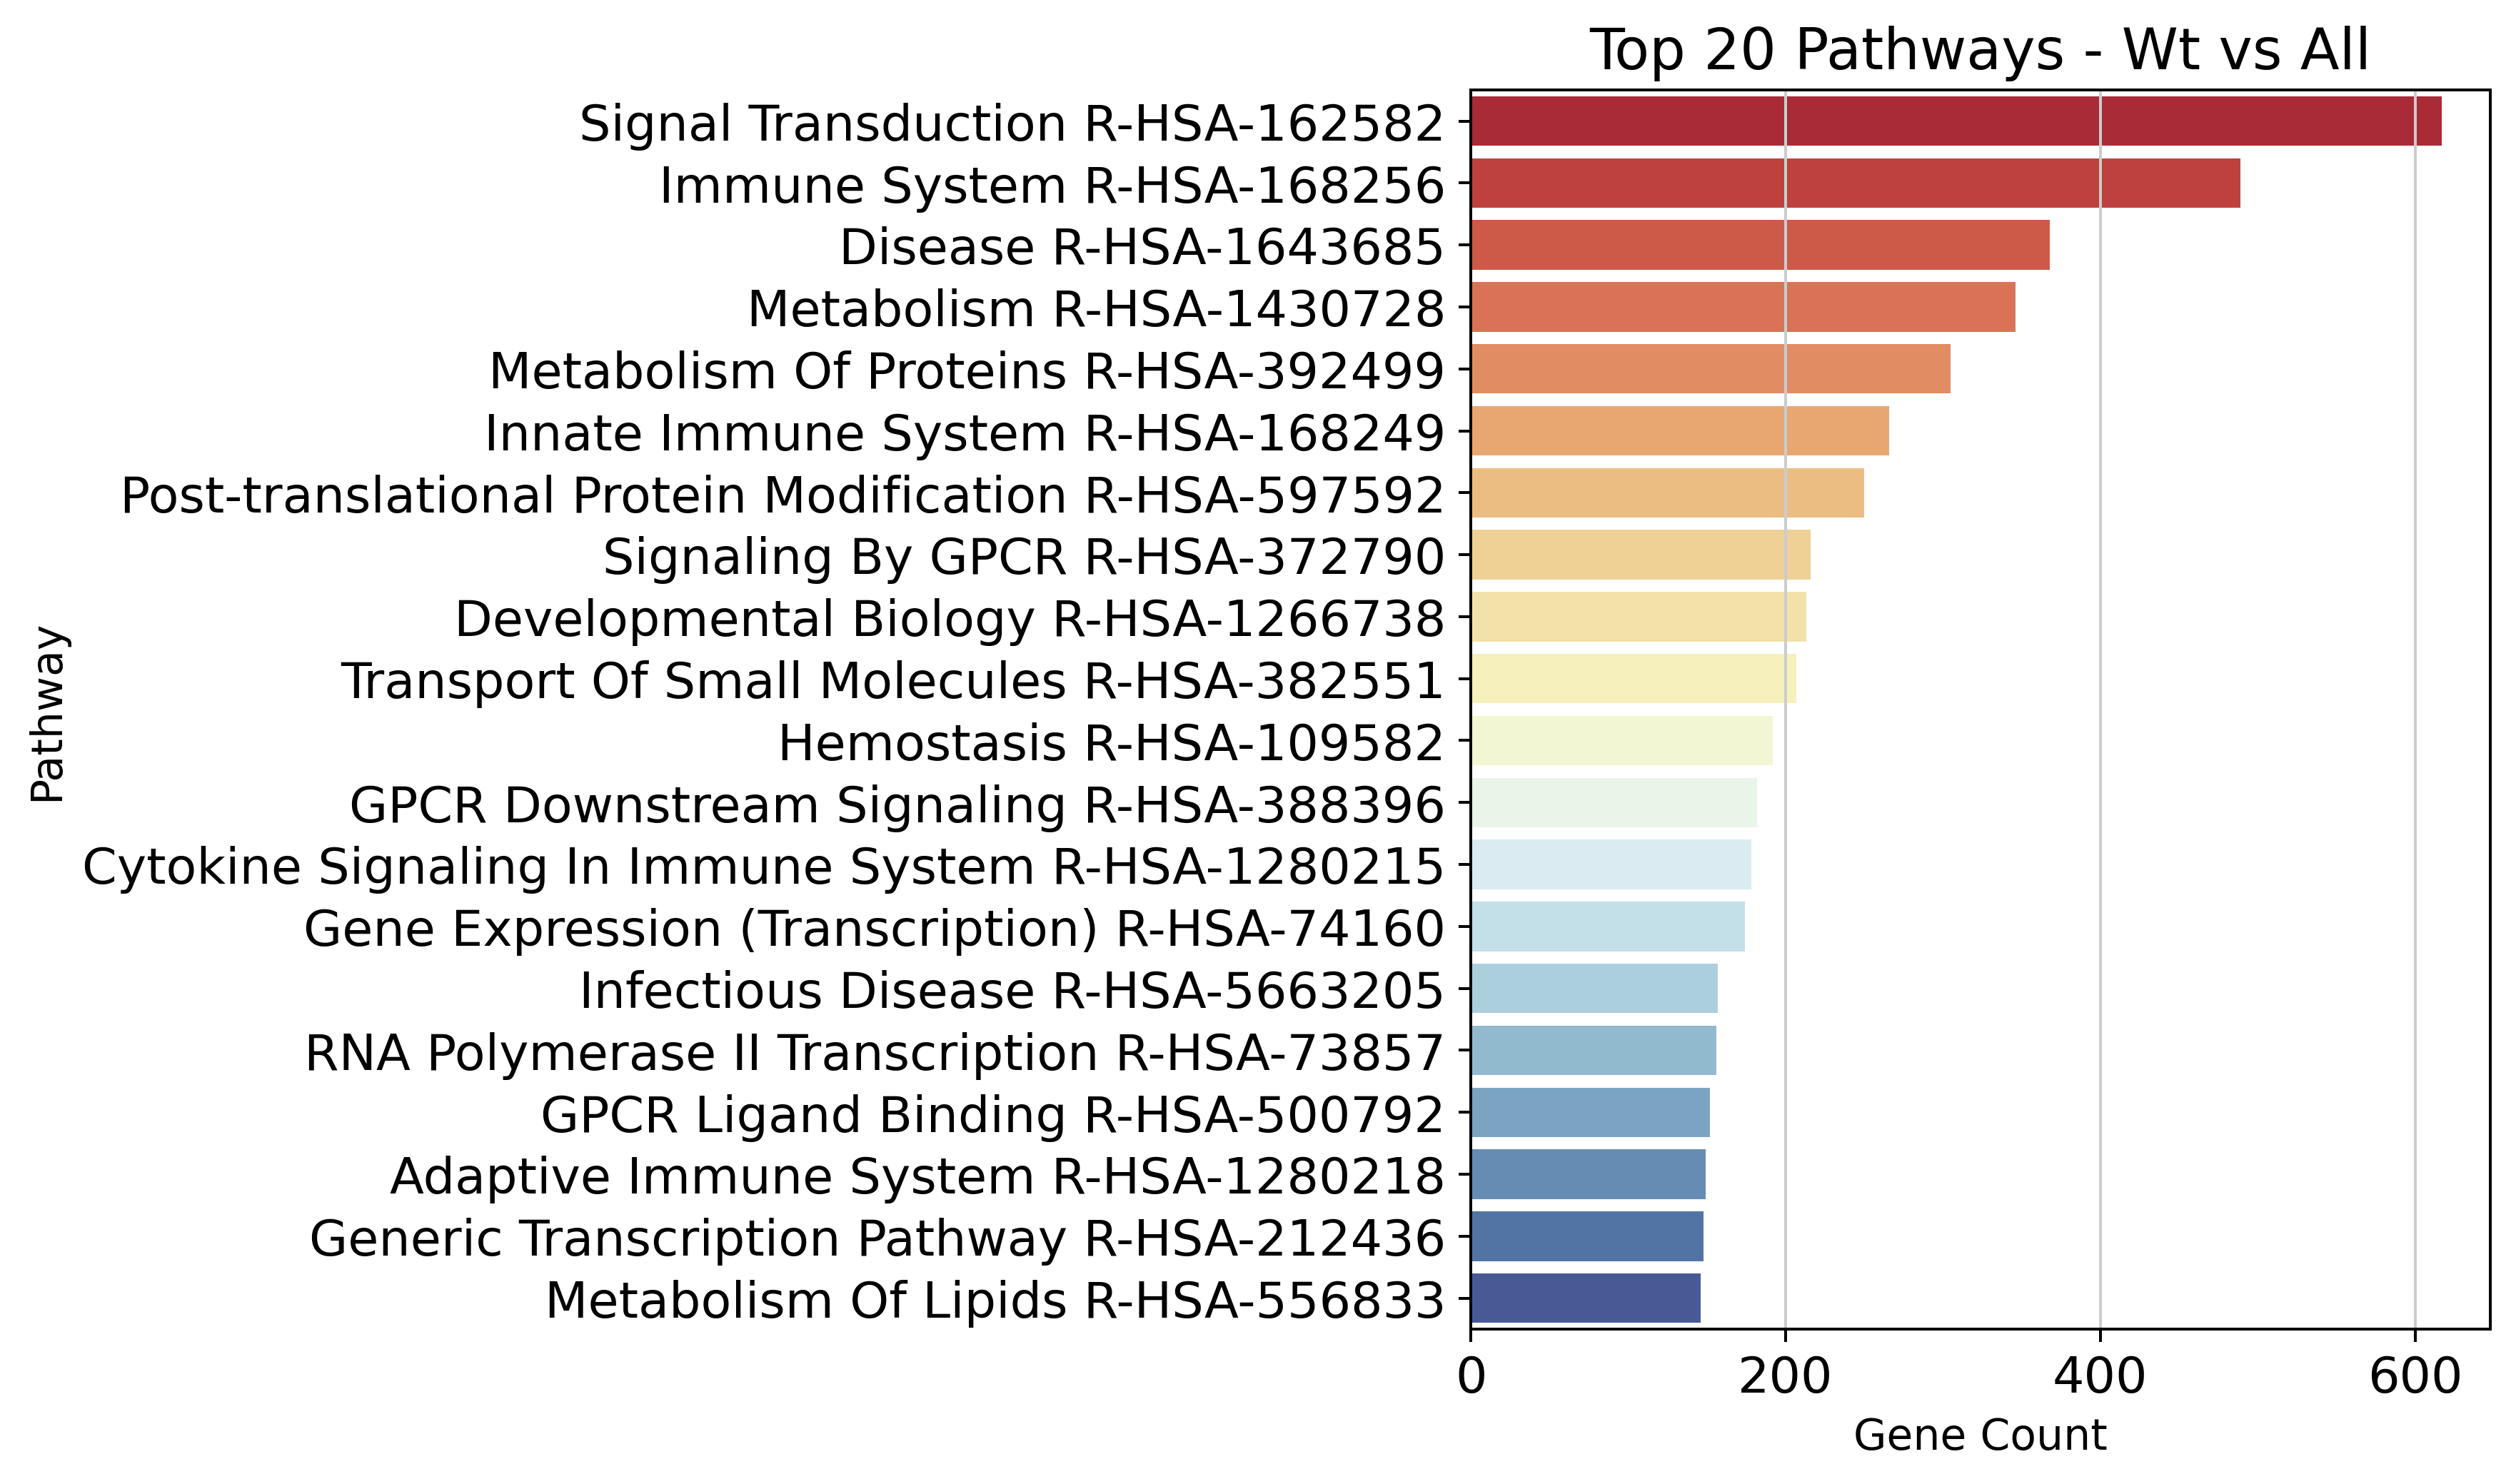

In [38]:
pathway_counts_sorted = pathway_counts_df.sort_values(by='Gene Count', ascending=False)

top_n = 20
plt.figure(figsize=(10, 6))
sns.barplot(x='Gene Count', y='Pathway', data=pathway_counts_sorted.head(top_n), palette='RdYlBu')
plt.title(f"Top {top_n} Pathways - Wt vs All", fontsize=16)
plt.xlabel('Gene Count', fontsize=12)
plt.ylabel('Pathway', fontsize=12)
plt.tight_layout()
plt.show()